Place for a picture

# Logistic Regression of a... (Phase Three Project)

## Business Problem/Question

Can we use factors from this dataset that are trackable by an insurance company to determining whether a private passenger vehicle crash in Chicago incurs property damage over $1,500 and can we make good predictions using these factors? 

## EDA

In [47]:
# Importing packages
import numpy as np
import pandas as pd 
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

### Read in and create new csv

In [17]:
# Read in data

df_vehicles = pd.read_csv("Data\Traffic_Crashes_-_Vehicles_20231109.csv", parse_dates=["CRASH_DATE"], low_memory=False)
df_people = pd.read_csv("Data\Traffic_Crashes_-_People_20231109.csv", parse_dates=["CRASH_DATE"], low_memory=False)
df_crashes = pd.read_csv("Data\Traffic_Crashes_-_Crashes_20231109.csv", parse_dates=["CRASH_DATE"], low_memory=False)

In [18]:
# Filter out any data from before 2021

df_crashes = df_crashes[df_crashes["CRASH_DATE"].dt.year >= 2021]
df_people = df_people[df_people["CRASH_DATE"].dt.year >= 2021]
df_vehicles = df_vehicles[df_vehicles["CRASH_DATE"].dt.year >= 2021]

Using the data dictionaries to understand column names, we are dropping columns from each set that are not relevant to the business problem.

In [19]:
# Drop columns from Vehicles dataframe

df_vehicles.drop(columns = ['UNIT_NO', 'LIC_PLATE_STATE', 'TRAVEL_DIRECTION', 'MANEUVER',
                            'TOWED_I', 'FIRE_I', 'TOWED_BY', 'TOWED_TO', 'AREA_00_I', 
                            'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I', 'AREA_05_I', 
                            'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 
                            'AREA_11_I', 'AREA_12_I', 'AREA_99_I', 'FIRST_CONTACT_POINT', 'CMV_ID', 
                            'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC', 'GVWR', 
                            'CARRIER_NAME', 'CARRIER_STATE', 'CARRIER_CITY',
                            'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO', 'HAZMAT_PRESENT_I', 
                            'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'MCS_REPORT_I',
                            'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I', 'MCS_VIO_CAUSE_CRASH_I', 
                            'IDOT_PERMIT_NO', 'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 
                            'TRAILER1_LENGTH', 'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH',
                            'AXLE_CNT', 'VEHICLE_CONFIG', 'CARGO_BODY_TYPE', 'LOAD_TYPE',
                            'HAZMAT_OUT_OF_SERVICE_I', 'MCS_OUT_OF_SERVICE_I', 'HAZMAT_CLASS'],
                            inplace=True)

In [20]:
# Drop columns from People dataframe

df_people.drop(columns = ['PERSON_ID', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SAFETY_EQUIPMENT', 
                          'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL', 
                          'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION', 'PHYSICAL_CONDITION',
                          'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE'], inplace=True)

In [21]:
# Drop columns from Crashes dataframe

df_crashes.drop(columns = ['CRASH_DATE_EST_I', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 
                           'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 
                           'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'FIRST_CRASH_TYPE', 'LANE_CNT', 
                           'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 
                           'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DATE_POLICE_NOTIFIED', 'STREET_NO', 
                           'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 
                           'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 
                           'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 
                           'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_MONTH', 
                           'LATITUDE', 'LONGITUDE', 'LOCATION'], inplace=True) 

Because we are most interested in vehicle damage, we are using the Vehicles dataframe as the main and merging the others into it.

In [22]:
# Merge People dataframe with Vehicles dataframe

df = df_vehicles.merge(df_people, how="left", on=["CRASH_RECORD_ID", "CRASH_DATE", "RD_NO", "VEHICLE_ID"])

In [23]:
# Merge Crashes dataframe with merged dataframe

df = pd.merge(df, df_crashes, how = 'inner', on = ['CRASH_RECORD_ID', "CRASH_DATE", "RD_NO"])

In [24]:
# Exporting new dataframe to csv for use throughout rest of notebook

df.to_csv("Data\chicago_traffic_accidents_2021_to_11-09-2023.csv")

### Working with a single merge dataset

In [185]:
# Can load merged dataframe without needing to go through above steps each time
df = pd.read_csv("Data\chicago_traffic_accidents_2021_to_11-09-2023.zip", 
                 parse_dates=["CRASH_DATE"], low_memory=False)

We don't need all the identifying columns as they are not useful in making a model. We will drop all of those now.

In [186]:
df.drop(columns = ["Unnamed: 0", "CRASH_UNIT_ID", "CRASH_RECORD_ID", 
                   "RD_NO", "VEHICLE_ID"], inplace=True)

We only want unique vehicle damage count, so we need to remove rows that represent passengers, as these will duplicate the vehicle damage. We also should remove any other rows that don't represent drivers. We can use the "PERSON_TYPE" column for this.

In [187]:
# Check values in Person_type column

df['PERSON_TYPE'].value_counts(normalize=True)

DRIVER                 0.780694
PASSENGER              0.197756
PEDESTRIAN             0.012899
BICYCLE                0.007730
NON-MOTOR VEHICLE      0.000760
NON-CONTACT VEHICLE    0.000162
Name: PERSON_TYPE, dtype: float64

In [188]:
# Remove all types of person except DRIVER

df = df[df['PERSON_TYPE'] == 'DRIVER']

In [189]:
# Sanity check

df['PERSON_TYPE'].value_counts(normalize=True)

DRIVER    1.0
Name: PERSON_TYPE, dtype: float64

### Missingness

Next we look at null values to try to determine which columns might need to be imputed or if the data is too incomplete to be useful. 

In [190]:
# First dropping columns that no longer have any data after removing all but DRIVER entries

df= df.dropna(axis=1, how="all")

In [191]:
# Looking at the total nulls left in remaining columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530319 entries, 0 to 766594
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_DATE               530319 non-null  datetime64[ns]
 1   UNIT_TYPE                530310 non-null  object        
 2   NUM_PASSENGERS           85079 non-null   float64       
 3   CMRC_VEH_I               10945 non-null   object        
 4   MAKE                     530098 non-null  object        
 5   MODEL                    530098 non-null  object        
 6   VEHICLE_YEAR             434488 non-null  float64       
 7   VEHICLE_DEFECT           530098 non-null  object        
 8   VEHICLE_TYPE             530098 non-null  object        
 9   VEHICLE_USE              530098 non-null  object        
 10  OCCUPANT_CNT             530098 non-null  float64       
 11  EXCEED_SPEED_LIMIT_I     9 non-null       object        
 12  PERSON_TYPE     

There are several columns that seem useful from the data dictionaries, but look almost entirely full of nulls. We do a value_counts for those columns to see what's in them.

In [192]:
# NUM_PASSENGERS

df["NUM_PASSENGERS"].value_counts(dropna=False)

NaN     445240
1.0      60610
2.0      15374
3.0       6037
4.0       2034
5.0        560
6.0        234
7.0         84
8.0         28
10.0        23
9.0         19
11.0        18
12.0        10
17.0         6
14.0         5
19.0         4
13.0         4
16.0         4
15.0         3
18.0         2
22.0         2
21.0         2
27.0         2
43.0         2
26.0         2
20.0         1
33.0         1
34.0         1
28.0         1
46.0         1
42.0         1
30.0         1
32.0         1
31.0         1
24.0         1
Name: NUM_PASSENGERS, dtype: int64

There is no 0 value, so the NaNs are problably 0. However, OCCUPANT_CNT represents the same information so we won't need this column. 

In [193]:
# CMRC_VEH_I

df["CMRC_VEH_I"].value_counts(dropna=False)

NaN    519374
Y        6602
N        4343
Name: CMRC_VEH_I, dtype: int64

This is a binary flag, but the missing values represent the overwhelming majority. We can drop the Y rows because they are commercial vehicles and do not fit the business problem, but the rest we will leave as we cannot make an assumption from such a small subset that the Y/N ratio is representative of the whole. 

In [194]:
# Dropping Commercial Vehicles

df = df[df["CMRC_VEH_I"]!="Y"]

In [195]:
# Sanity Check

df["CMRC_VEH_I"].value_counts(dropna=False)

NaN    519374
N        4343
Name: CMRC_VEH_I, dtype: int64

In [196]:
# EXCEED_SPEED_LIMIT_I

df["EXCEED_SPEED_LIMIT_I"].value_counts(dropna=False)

NaN    523708
N           5
Y           4
Name: EXCEED_SPEED_LIMIT_I, dtype: int64

This is a binary flag, but the missing values represent the overwhelming majority. We cannot make an assumption from such a small subset that the Y/N ratio is representative of the whole. This does not seem to be a useful column.

In [197]:
# AGE

df["AGE"].value_counts(dropna=False)

NaN      152142
28.0      10738
27.0      10706
29.0      10618
26.0      10583
          ...  
101.0         5
102.0         4
103.0         3
98.0          3
110.0         2
Name: AGE, Length: 106, dtype: int64

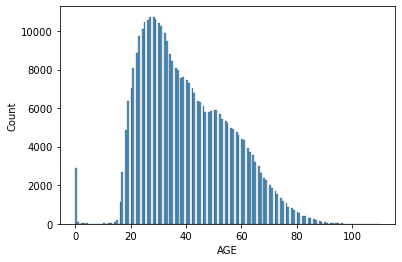

In [198]:
sns.histplot(df["AGE"]);

Missing values is a smaller percentage, and the mean of age seems to make sense, so we can impute the mean later on and keep this column.

In [199]:
# CELL_PHONE_USE

df["CELL_PHONE_USE"].value_counts(dropna=False)

NaN    523715
N           2
Name: CELL_PHONE_USE, dtype: int64

This is a binary flag, but the missing values represent the overwhelming majority. We cannot make an assumption from such a small subset that the Y/N ratio is representative of the whole. This does not seem to be a useful column.

In [200]:
# Dropping all columns determined not to be useful

df.drop(columns = ["CMRC_VEH_I", "EXCEED_SPEED_LIMIT_I", "CELL_PHONE_USE"], inplace=True)

In [201]:
#Sanity Check

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523717 entries, 0 to 766594
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_DATE               523717 non-null  datetime64[ns]
 1   UNIT_TYPE                523708 non-null  object        
 2   NUM_PASSENGERS           84450 non-null   float64       
 3   MAKE                     523496 non-null  object        
 4   MODEL                    523496 non-null  object        
 5   VEHICLE_YEAR             428682 non-null  float64       
 6   VEHICLE_DEFECT           523496 non-null  object        
 7   VEHICLE_TYPE             523496 non-null  object        
 8   VEHICLE_USE              523496 non-null  object        
 9   OCCUPANT_CNT             523496 non-null  float64       
 10  PERSON_TYPE              523717 non-null  object        
 11  SEX                      523717 non-null  object        
 12  AGE             

### Compare Variables

In [202]:
# Check out the rest of the variables for weirdness

df.describe(include="all")

<ipython-input-202-b1800870b00c>:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include="all")


,CRASH_DATE,UNIT_TYPE,NUM_PASSENGERS,MAKE,MODEL,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,OCCUPANT_CNT,...,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,BEAT_OF_OCCURRENCE,CRASH_HOUR,CRASH_DAY_OF_WEEK
count,523717,523708,84450.000000,523496,523496,428682.000000,523496,523496,523496,523496.000000,...,523717,371575.000000,384260,302924,523717,523717,523717,523717.000000,523717.000000,523717.000000
unique,204665,5,NaN,628,1694,NaN,17,21,23,NaN,...,3,NaN,174,176,3,38,38,NaN,NaN,NaN
top,2022-02-17 15:30:00,DRIVER,NaN,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),NaN,UNKNOWN,PASSENGER,PERSONAL,NaN,...,M,NaN,IL,D,"OVER $1,500",UNABLE TO DETERMINE,NOT APPLICABLE,NaN,NaN,NaN
freq,37,523684,NaN,61453,98351,NaN,272814,322655,351807,NaN,...,275960,NaN,350874,267251,360020,202712,214936,NaN,NaN,NaN
first,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-11-09 02:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.456945,NaN,NaN,2014.883128,NaN,NaN,NaN,1.234516,...,NaN,39.925474,NaN,NaN,NaN,NaN,NaN,1239.549677,13.360557,4.137664
std,NaN,NaN,0.995520,NaN,NaN,118.634721,NaN,NaN,NaN,0.667260,...,NaN,15.843725,NaN,NaN,NaN,NaN,NaN,701.016896,5.512825,1.982557
min,NaN,NaN,1.000000,NaN,NaN,1900.000000,NaN,NaN,NaN,0.000000,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,111.000000,0.000000,1.000000
25%,NaN,NaN,1.000000,NaN,NaN,2009.000000,NaN,NaN,NaN,1.000000,...,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,715.000000,10.000000,2.000000


Look at VEHICLE_YEAR because max is 9999.

In [203]:
# First we'll see how many vehicles have vehicle years that are not possible

future_cars = df[df["VEHICLE_YEAR"] > 2024]
future_cars["VEHICLE_YEAR"].count()

308

In [204]:
# See if anything else is apparent about these rows

future_cars.head()

,CRASH_DATE,UNIT_TYPE,NUM_PASSENGERS,MAKE,MODEL,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,OCCUPANT_CNT,...,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,BEAT_OF_OCCURRENCE,CRASH_HOUR,CRASH_DAY_OF_WEEK
773,2023-04-24 14:13:00,DRIVER,NaN,ACURA,ILX,2032.0,UNKNOWN,PASSENGER,PERSONAL,1.0,...,F,46.0,NaN,D,"OVER $1,500",IMPROPER TURNING/NO SIGNAL,NOT APPLICABLE,123.0,14,2
1823,2023-08-18 16:00:00,DRIVER,NaN,HONDA,HR-V,2108.0,NONE,SPORT UTILITY VEHICLE (SUV),PERSONAL,1.0,...,F,41.0,NaN,NaN,"$501 - $1,500",NOT APPLICABLE,NOT APPLICABLE,922.0,16,6
4078,2023-04-26 21:05:00,DRIVER,NaN,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),9999.0,UNKNOWN,OTHER,UNKNOWN/NA,1.0,...,X,NaN,NaN,NaN,$500 OR LESS,UNABLE TO DETERMINE,UNABLE TO DETERMINE,2212.0,21,4
5209,2023-04-27 10:00:00,DRIVER,NaN,NISSAN,ROGUE,2212.0,NONE,PASSENGER,PERSONAL,1.0,...,M,NaN,IL,D,"OVER $1,500",UNABLE TO DETERMINE,NOT APPLICABLE,1632.0,10,5
8326,2023-08-20 02:00:00,DRIVER,NaN,UNKNOWN,MOTORIZED,9999.0,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,1.0,...,X,NaN,NaN,NaN,"OVER $1,500",UNABLE TO DETERMINE,NOT APPLICABLE,1811.0,2,1


In [205]:
# Percent of rows with future VEHICLE_YEARS

len(future_cars)/len(df)*100

0.05881038805308974

In [206]:
# Nothing seems apparently off about these vehicles, 
# but as they are such a small percentage we will drop them out

df = df[df["VEHICLE_YEAR"] <= 2024]

In [207]:
# Looking at the first years now

df["VEHICLE_YEAR"].value_counts().sort_index()

1900.0      136
1901.0       16
1902.0        1
1929.0        1
1939.0        1
          ...  
2020.0    24966
2021.0    19736
2022.0    11825
2023.0     4988
2024.0      334
Name: VEHICLE_YEAR, Length: 72, dtype: int64

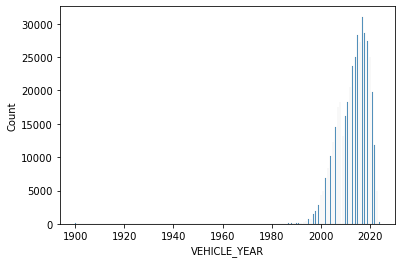

In [208]:
sns.histplot(df["VEHICLE_YEAR"]);

Looking at the rest of the columns.

In [209]:
df["VEHICLE_TYPE"].value_counts()

PASSENGER                                 290815
SPORT UTILITY VEHICLE (SUV)                69041
VAN/MINI-VAN                               18805
PICKUP                                     15608
UNKNOWN/NA                                 11671
TRUCK - SINGLE UNIT                         6775
OTHER                                       4638
BUS OVER 15 PASS.                           4313
TRACTOR W/ SEMI-TRAILER                     2183
BUS UP TO 15 PASS.                          1629
MOTORCYCLE (OVER 150CC)                     1165
SINGLE UNIT TRUCK WITH TRAILER               631
OTHER VEHICLE WITH TRAILER                   525
TRACTOR W/O SEMI-TRAILER                     331
MOPED OR MOTORIZED BICYCLE                   153
AUTOCYCLE                                     29
3-WHEELED MOTORCYCLE (2 REAR WHEELS)          23
ALL-TERRAIN VEHICLE (ATV)                     22
FARM EQUIPMENT                                14
RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)         3
Name: VEHICLE_TYPE, 

We're not interested in all these vehicle types, so we will remove everything that is explicitly not a passenger vehicle.

In [210]:
keep_vehicle = ["PASSENGER", "PICKUP", "SINGLE UNIT TRUCK WITH TRAILER", 
                "SPORT UTILITY VEHICLE (SUV)", "TRUCK - SINGLE UNIT", 
                "UNKNOWN/NA", "VAN/MINI-VAN"]

In [211]:
df = df[df["VEHICLE_TYPE"].isin(keep_vehicle)]

In [212]:
# Sanity check

df["VEHICLE_TYPE"].value_counts()

PASSENGER                         290815
SPORT UTILITY VEHICLE (SUV)        69041
VAN/MINI-VAN                       18805
PICKUP                             15608
UNKNOWN/NA                         11671
TRUCK - SINGLE UNIT                 6775
SINGLE UNIT TRUCK WITH TRAILER       631
Name: VEHICLE_TYPE, dtype: int64

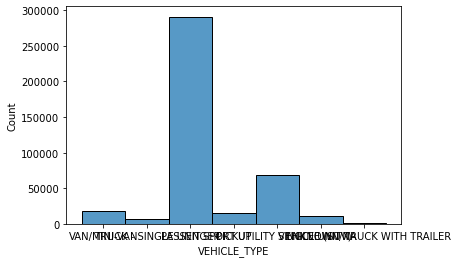

In [213]:
sns.histplot(df["VEHICLE_TYPE"]);

It seems too lopsided to use in model, but it was useful to filter out Vehicle Types that do not fit the business problem. 

In [214]:
df["VEHICLE_USE"].value_counts(dropna=False)

PERSONAL                        326549
UNKNOWN/NA                       59520
OTHER                            10260
RIDESHARE SERVICE                 3464
TAXI/FOR HIRE                     3006
POLICE                            2620
COMMERCIAL - SINGLE UNIT          2473
NOT IN USE                        1941
CONSTRUCTION/MAINTENANCE          1454
TOW TRUCK                          417
DRIVER EDUCATION                   372
STATE OWNED                        277
COMMERCIAL - MULTI-UNIT            273
AMBULANCE                          194
FIRE                               154
CTA                                152
LAWN CARE/LANDSCAPING              114
SCHOOL BUS                          46
AGRICULTURE                         29
CAMPER/RV - SINGLE UNIT             16
MILITARY                            10
HOUSE TRAILER                        4
CAMPER/RV - TOWED/MULTI-UNIT         1
Name: VEHICLE_USE, dtype: int64

We only want personal vehicles, so we will remove the rest.

In [215]:
df = df[df["VEHICLE_USE"]=="PERSONAL"]

In [216]:
df["CRASH_DATE"].value_counts(dropna=False)

2021-02-04 14:00:00    24
2022-02-17 15:30:00    21
2021-02-04 13:30:00    20
2021-11-19 15:30:00    20
2021-12-10 16:00:00    20
                       ..
2021-09-29 10:43:00     1
2022-11-27 23:32:00     1
2021-01-28 22:15:00     1
2022-05-31 09:50:00     1
2023-03-12 04:00:00     1
Name: CRASH_DATE, Length: 162040, dtype: int64

We are not doing a time analysis, so this will not be used in our model. 

In [217]:
df["UNIT_TYPE"].value_counts(dropna=False)

DRIVER    326549
Name: UNIT_TYPE, dtype: int64

This corresponds to PERSON_TYPE. We will not use either in our model as it was used to filter the data.

In [218]:
df["MAKE"].value_counts(dropna=False)[:5]

TOYOTA       42173
CHEVROLET    41785
NISSAN       31144
HONDA        30588
FORD         29433
Name: MAKE, dtype: int64

In [219]:
top_makes = df['MAKE'].value_counts()[:10]
top_makes

TOYOTA        42173
CHEVROLET     41785
NISSAN        31144
HONDA         30588
FORD          29433
JEEP          17840
HYUNDAI       17436
DODGE         14028
KIA           12001
VOLKSWAGEN     8045
Name: MAKE, dtype: int64

In [247]:
df_top_makes = df[df['MAKE'].count() > 10000]
#df_top_makes.dropna(subset = ['MAKE'])
df_top_makes['MAKE'].value_counts(dropna=False)


KeyError: True

In [243]:
counts = {'OTHER':0}
for company in df["MAKE"]:
    if company in top_makes:
        if company in counts:
            counts[company] +=1
        else:
            counts[company] = 1
    else:
        counts['OTHER'] +=1
       
counts

{'OTHER': 82076,
 'HYUNDAI': 17436,
 'CHEVROLET': 41785,
 'NISSAN': 31144,
 'FORD': 29433,
 'JEEP': 17840,
 'HONDA': 30588,
 'TOYOTA': 42173,
 'KIA': 12001,
 'DODGE': 14028,
 'VOLKSWAGEN': 8045}

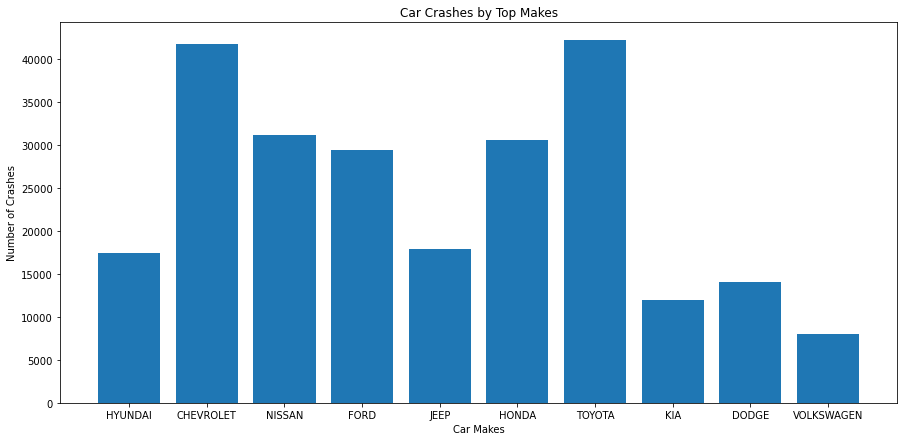

In [87]:

x = list(counts.keys())
y = list(counts.values())
fig = plt.figure(figsize = (15, 7))
plt.bar(x, y);
plt.xlabel("Car Makes")
plt.ylabel("Number of Crashes")
plt.title("Car Crashes by Top Makes")
plt.show()

In [179]:
# Create a feature for amateur vs professional builds by total fatalities and show percentages
accidents_by_make = pd.crosstab(df['DAMAGE_OVER_1500'], df['MAKE'].value_counts()[:10], normalize = 'columns')
print(accidents_by_make)

Empty DataFrame
Columns: []
Index: []


In [ ]:
import matplotlib.ticker as mtick

# Set figure size
makes_fig, makes_ax = plt.subplots(figsize=(8, 7))

# Create plot
makes_ax.set_title('Accidents by Car Make')
makes_ax.set_ylabel('Number of Accidents')
makes_ax.set_xlabel('Car Brands')

# Create conditions for build type and percentages per total accident fatalities
make_type = accidents_by_make.columns
under = accidents_by_make.loc[False]*100
over = accidents_by_make.loc[True]*100

non_fatal_bar_plt = accidents_by_build_ax.bar(build_type, non_fatal )
fatal_bar_plt = accidents_by_build_ax.bar(build_type, fatal, bottom = non_fatal )

# Format plot
accidents_by_build_ax.legend([non_fatal_bar_plt, fatal_bar_plt], ["Non-Fatal", "Fatal"], loc = 'upper right')
accidents_by_build_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
accidents_by_build_ax.set_xticks([0, 1])
accidents_by_build_ax.set_xticklabels(['Professional', 'Amateur'])
accidents_by_build_ax.set_xlim(-.5, 2)

plt.show();

This could be useful in our model. We will probably filter for top makes if we do use it.

In [88]:
df["MODEL"].value_counts(dropna=False)

OTHER (EXPLAIN IN NARRATIVE)                      25347
CAMRY                                             11200
COROLLA                                            8330
CIVIC                                              7963
ALTIMA                                             7799
                                                  ...  
LIGHT EQUIPMENT DIVISION, DIV, OF J.I.CASD CO.        1
D40LF                                                 1
CORDOBA                                               1
PHANTOM                                               1
MODEL A                                               1
Name: MODEL, Length: 1182, dtype: int64

This could be useful. We may use it with MAKE and determine after filtering for top makes. Will need to avoid multicollinearity.

In [89]:
df["VEHICLE_DEFECT"].value_counts(dropna=False)

NONE                195277
UNKNOWN             127516
OTHER                 1485
BRAKES                1365
TIRES                  268
STEERING               254
WHEELS                 131
SUSPENSION              93
ENGINE/MOTOR            64
FUEL SYSTEM             39
WINDOWS                 19
LIGHTS                  15
SIGNALS                  9
CARGO                    7
EXHAUST                  3
RESTRAINT SYSTEM         2
TRAILER COUPLING         2
Name: VEHICLE_DEFECT, dtype: int64

Lot of UNKNOWN. Possibly useful, but even if we bin between NONE and all other variables the data would still be lopsided. Will not use in model.

In [91]:
df["OCCUPANT_CNT"].value_counts(dropna=False, normalize=True)

1.0     0.807726
2.0     0.136200
3.0     0.035894
4.0     0.013958
5.0     0.004587
6.0     0.001106
7.0     0.000401
8.0     0.000089
9.0     0.000021
0.0     0.000012
10.0    0.000003
11.0    0.000003
Name: OCCUPANT_CNT, dtype: float64

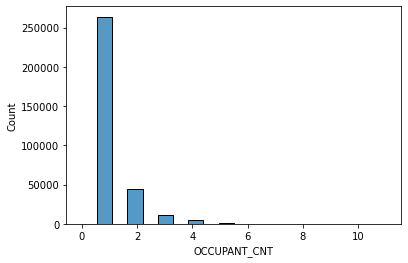

In [92]:
sns.histplot(df["OCCUPANT_CNT"]);

Could bin into HAS_PASSENGER but harder to track and implement for stakeholder. Would still be pretty lopsided. 

In [93]:
df["SEX"].value_counts(dropna=False, normalize=True)

M    0.554924
F    0.430625
X    0.014451
Name: SEX, dtype: float64

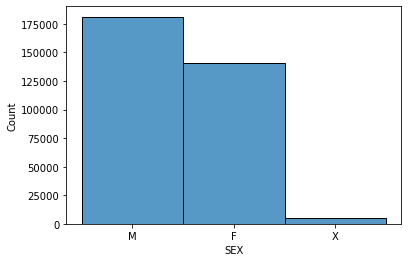

In [94]:
sns.histplot(df["SEX"]);

X is a small percentage and represents an unknown. We may drop later.

In [95]:
df["DRIVERS_LICENSE_STATE"].value_counts(dropna=False)

IL     271946
NaN     34744
IN       4760
XX       2037
WI       1552
        ...  
AT          1
CJ          1
HK          1
MW          1
IO          1
Name: DRIVERS_LICENSE_STATE, Length: 166, dtype: int64

Bin for in state and out of state. 

In [96]:
df["DRIVERS_LICENSE_CLASS"].value_counts(dropna=False, normalize=True)

D      0.671951
NaN    0.270186
C      0.016310
A      0.013101
DM     0.008235
         ...   
N0     0.000003
.D     0.000003
SD     0.000003
--     0.000003
MO     0.000003
Name: DRIVERS_LICENSE_CLASS, Length: 150, dtype: float64

Data is lopsided and contains a fair bit missing.

In [97]:
df["BEAT_OF_OCCURRENCE"].value_counts(dropna=False, normalize=True)

813.0     0.011563
114.0     0.010571
815.0     0.010277
1834.0    0.010014
833.0     0.009827
            ...   
1653.0    0.000628
1655.0    0.000447
1652.0    0.000254
1650.0    0.000119
6100.0    0.000003
Name: BEAT_OF_OCCURRENCE, Length: 276, dtype: float64

Data not easily useable by stakeholder. May be useful for future projects.

In [98]:
df["CRASH_HOUR"].value_counts(dropna=False, normalize=True)

15    0.086012
16    0.084643
17    0.080588
14    0.069187
18    0.064817
13    0.061409
12    0.057841
8     0.052237
11    0.049000
19    0.046214
10    0.042361
9     0.041767
7     0.041253
20    0.037122
21    0.032620
22    0.028865
23    0.025497
0     0.018879
6     0.018052
1     0.016417
2     0.014019
5     0.011426
3     0.010559
4     0.009215
Name: CRASH_HOUR, dtype: float64

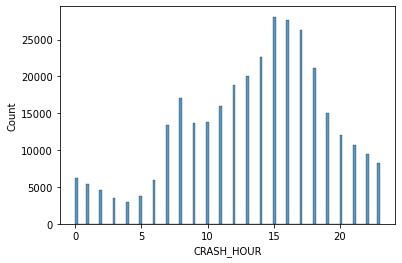

In [99]:
sns.histplot(df["CRASH_HOUR"]);

Bin to times of day.

In [100]:
df["CRASH_DAY_OF_WEEK"].value_counts(dropna=False, normalize=True)

6    0.166107
7    0.150186
5    0.145571
3    0.140579
4    0.140555
2    0.131962
1    0.125041
Name: CRASH_DAY_OF_WEEK, dtype: float64

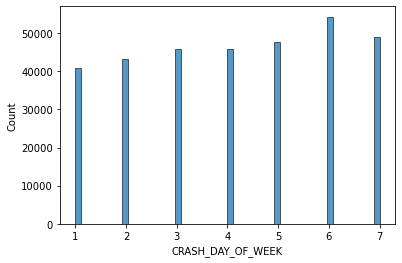

In [101]:
sns.histplot(df["CRASH_DAY_OF_WEEK"]);

Bin with CRASH_HOUR for times of day.

In [102]:
df["PRIM_CONTRIBUTORY_CAUSE"].value_counts(dropna=False)

UNABLE TO DETERMINE                                                                 106487
FAILING TO YIELD RIGHT-OF-WAY                                                        48046
FOLLOWING TOO CLOSELY                                                                37565
IMPROPER OVERTAKING/PASSING                                                          17666
FAILING TO REDUCE SPEED TO AVOID CRASH                                               16721
IMPROPER TURNING/NO SIGNAL                                                           13355
NOT APPLICABLE                                                                       13207
IMPROPER LANE USAGE                                                                  11245
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  11188
DISREGARDING TRAFFIC SIGNALS                                                          9944
IMPROPER BACKING                                                                      9615

The only possibly useful data point is what can be known demographically before a crash. So DRIVING SKILLS/KNOWLEDGE/EXPERIENCE should be made into a flag.

In [103]:
df["SEC_CONTRIBUTORY_CAUSE"].value_counts(dropna=False)

NOT APPLICABLE                                                                      131381
UNABLE TO DETERMINE                                                                 110350
FAILING TO YIELD RIGHT-OF-WAY                                                        14184
FAILING TO REDUCE SPEED TO AVOID CRASH                                               13610
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                  11087
FOLLOWING TOO CLOSELY                                                                10854
IMPROPER OVERTAKING/PASSING                                                           5666
IMPROPER LANE USAGE                                                                   4878
IMPROPER TURNING/NO SIGNAL                                                            4524
WEATHER                                                                               3997
IMPROPER BACKING                                                                      2019

DRIVING SKILLS/KNOWLEDGE/EXPERIENCE used with same above for a flag.

## Feature Engineering

Binning in state and out of state without losing the null values. We will impute after Train/Test Split.

In [104]:
states = sorted(df["DRIVERS_LICENSE_STATE"].value_counts().index)
states.remove('IL')

In [105]:
def in_state(row):
    if row['DRIVERS_LICENSE_STATE'] == 'IL':
        return 1
    elif row['DRIVERS_LICENSE_STATE'] in states:
        return 0

df['IN_STATE'] = df.apply(in_state, axis=1)

In [106]:
# Sanity check 

df["IN_STATE"].value_counts(dropna=False)

1.0    271946
NaN     34744
0.0     19859
Name: IN_STATE, dtype: int64

We are interested in driving skills, knowledge, or experience as a contributing cause of accidents.

In [107]:
(df['PRIM_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE').value_counts(normalize=True)

False    0.965739
True     0.034261
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: float64

In [108]:
(df['SEC_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE').value_counts(normalize=True)

False    0.966048
True     0.033952
Name: SEC_CONTRIBUTORY_CAUSE, dtype: float64

In [109]:
((df['PRIM_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE') & (df['SEC_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE')).value_counts(normalize=True)

False    0.994396
True     0.005604
dtype: float64

In [110]:
# Create a new column to identify any contributory cause as "driving skills/knowledge/experience"

def get_cause(row):
    if row['PRIM_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE':
        return 1
    if row['SEC_CONTRIBUTORY_CAUSE'] == 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE':
        return 1
    else:
        return 0
df['DRIVING_SKILLS'] = df.apply(get_cause, axis=1)
   

In [111]:
df['DRIVING_SKILLS'].value_counts(normalize=True)

0    0.937391
1    0.062609
Name: DRIVING_SKILLS, dtype: float64

In [112]:
df.groupby("DRIVING_SKILLS").DAMAGE.value_counts(normalize=True)

DRIVING_SKILLS  DAMAGE       
0               OVER $1,500      0.707256
                $501 - $1,500    0.221604
                $500 OR LESS     0.071139
1               OVER $1,500      0.728100
                $501 - $1,500    0.197261
                $500 OR LESS     0.074639
Name: DAMAGE, dtype: float64

While DRIVING_SKILLS is a very lopsided value, there is an indication that it affects the DAMAGE. We may be able to SMOTE this for our model.

We want to identify crashes by the time of day they occurred.

In [113]:
# Create a new column to identify the time of day crashes occurred

def hour(row):
    if (row['CRASH_HOUR'] < 7) or (row['CRASH_HOUR'] >23):
        return 'Evening/Overnight'
    elif (row['CRASH_DAY_OF_WEEK'] in range(2,7)) and (row['CRASH_HOUR'] in range(7,10)) or (row['CRASH_HOUR'] in range(16,19)):
        return 'Commute'
    elif row['CRASH_HOUR'] in range(19,24):
        return 'Evening/Overnight'
    else:
        return 'Daytime'
df['TIME_OF_DAY'] = df.apply(hour, axis=1)

In [114]:
df['TIME_OF_DAY'].value_counts(dropna=False, normalize=True)

Daytime              0.384604
Commute              0.346512
Evening/Overnight    0.268885
Name: TIME_OF_DAY, dtype: float64

In [115]:
# Check the values in Damage column

df['DAMAGE'].value_counts()

OVER $1,500      231380
$501 - $1,500     71867
$500 OR LESS      23302
Name: DAMAGE, dtype: int64

In [116]:
# Create a new column to identify damage as > $1500 or <= $1500

damage_dict = {'OVER $1,500':1, '$501 - $1,500':0, '$500 OR LESS':0}
df['DAMAGE_OVER_1500'] =  df.loc[:, ('DAMAGE')].map(damage_dict).copy()

In [117]:
# Sanity check

df['DAMAGE_OVER_1500'].value_counts()

1    231380
0     95169
Name: DAMAGE_OVER_1500, dtype: int64

### Comparing columns to DAMAGE_OVER_1500

In [118]:
df.groupby("AGE").DAMAGE_OVER_1500.value_counts().sort_values(ascending=False)

AGE    DAMAGE_OVER_1500
28.0   1                   6294
25.0   1                   6170
26.0   1                   6137
29.0   1                   6130
27.0   1                   6114
                           ... 
103.0  1                      2
6.0    0                      1
10.0   0                      1
102.0  0                      1
110.0  1                      1
Name: DAMAGE_OVER_1500, Length: 204, dtype: int64

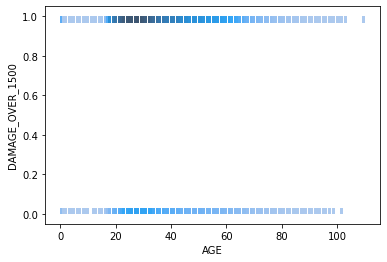

In [119]:
sns.histplot(x=df["AGE"], y=df["DAMAGE_OVER_1500"]);

In [120]:
df.groupby("VEHICLE_YEAR").DAMAGE_OVER_1500.value_counts().sort_values(ascending=False)

VEHICLE_YEAR  DAMAGE_OVER_1500
2017.0        1                   16795
2018.0        1                   15685
2015.0        1                   15457
2016.0        1                   14889
2019.0        1                   14442
                                  ...  
1962.0        1                       1
1963.0        0                       1
1964.0        0                       1
1970.0        0                       1
1975.0        0                       1
Name: DAMAGE_OVER_1500, Length: 131, dtype: int64

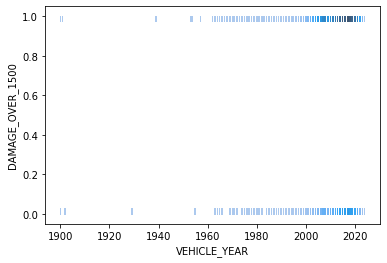

In [121]:
sns.histplot(x=df["VEHICLE_YEAR"], y=df["DAMAGE_OVER_1500"]);

In [122]:
df.groupby("TIME_OF_DAY").DAMAGE_OVER_1500.value_counts()

TIME_OF_DAY        DAMAGE_OVER_1500
Commute            1                   78312
                   0                   34841
Daytime            1                   85978
                   0                   39614
Evening/Overnight  1                   67090
                   0                   20714
Name: DAMAGE_OVER_1500, dtype: int64

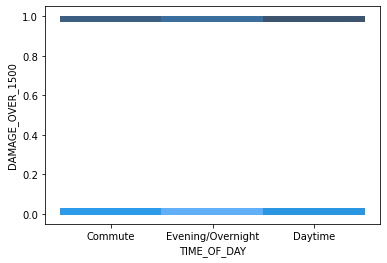

In [123]:
sns.histplot(x=df["TIME_OF_DAY"], y=df["DAMAGE_OVER_1500"]);

In [124]:
df.groupby("SEX").DAMAGE_OVER_1500.value_counts()

SEX  DAMAGE_OVER_1500
F    1                    98163
     0                    42457
M    1                   129770
     0                    51440
X    1                     3447
     0                     1272
Name: DAMAGE_OVER_1500, dtype: int64

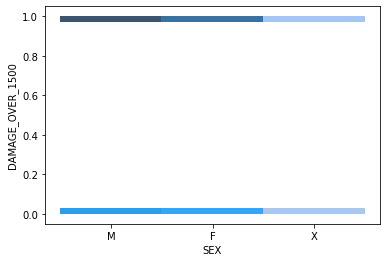

In [125]:
sns.histplot(x=df["SEX"], y=df["DAMAGE_OVER_1500"]);

In [126]:
df.groupby("IN_STATE").DAMAGE_OVER_1500.value_counts()

IN_STATE  DAMAGE_OVER_1500
0.0       1                    13920
          0                     5939
1.0       1                   194064
          0                    77882
Name: DAMAGE_OVER_1500, dtype: int64

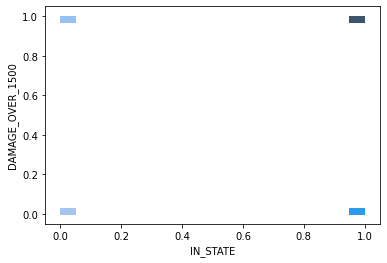

In [127]:
sns.histplot(x=df["IN_STATE"], y=df["DAMAGE_OVER_1500"]);

In [128]:
df.groupby("CRASH_HOUR").DAMAGE_OVER_1500.value_counts()

CRASH_HOUR  DAMAGE_OVER_1500
0           1                    4972
            0                    1193
1           1                    4330
            0                    1031
2           1                    3810
            0                     768
3           1                    2883
            0                     565
4           1                    2537
            0                     472
5           1                    2980
            0                     751
6           1                    4502
            0                    1393
7           1                    9789
            0                    3682
8           1                   12031
            0                    5027
9           1                    9712
            0                    3927
10          1                    9794
            0                    4039
11          1                   11172
            0                    4829
12          1                   12883
            0        

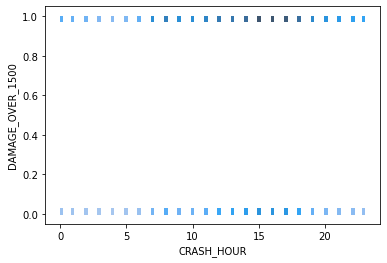

In [129]:
sns.histplot(x=df["CRASH_HOUR"], y=df["DAMAGE_OVER_1500"]);

## Dummy Model

### Decide Xs/y

The target is DAMAGE_OVER_1500. There are a few columns which represent interrelated variables, so only one will be used. 

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326549 entries, 3 to 766594
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   CRASH_DATE               326549 non-null  datetime64[ns]
 1   UNIT_TYPE                326549 non-null  object        
 2   NUM_PASSENGERS           62843 non-null   float64       
 3   MAKE                     326549 non-null  object        
 4   MODEL                    326549 non-null  object        
 5   VEHICLE_YEAR             326549 non-null  float64       
 6   VEHICLE_DEFECT           326549 non-null  object        
 7   VEHICLE_TYPE             326549 non-null  object        
 8   VEHICLE_USE              326549 non-null  object        
 9   OCCUPANT_CNT             326549 non-null  float64       
 10  PERSON_TYPE              326549 non-null  object        
 11  SEX                      326549 non-null  object        
 12  AGE             

In [131]:
X = df.drop(["DAMAGE", "DAMAGE_OVER_1500"], axis=1)
y = df["DAMAGE_OVER_1500"]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024)

In [133]:
dummy_model = DummyClassifier(strategy="most_frequent")

In [134]:
dummy_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [135]:
y_pred = dummy_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7095592738675617

# Model 2

In [136]:
df.head()

,CRASH_DATE,UNIT_TYPE,NUM_PASSENGERS,MAKE,MODEL,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,OCCUPANT_CNT,...,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,BEAT_OF_OCCURRENCE,CRASH_HOUR,CRASH_DAY_OF_WEEK,IN_STATE,DRIVING_SKILLS,TIME_OF_DAY,DAMAGE_OVER_1500
3,2023-08-09 09:52:00,DRIVER,NaN,HYUNDAI,TUCSON,2023.0,NONE,PASSENGER,PERSONAL,1.0,...,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,1213.0,9,4,1.0,0,Commute,1
4,2023-08-09 09:52:00,DRIVER,NaN,MAZDA,CX-5,2016.0,NONE,PASSENGER,PERSONAL,1.0,...,"OVER $1,500",FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,1213.0,9,4,1.0,0,Commute,1
5,2023-08-09 16:55:00,DRIVER,NaN,CHEVROLET,MALIBU,2013.0,UNKNOWN,PASSENGER,PERSONAL,1.0,...,"OVER $1,500","OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",FAILING TO REDUCE SPEED TO AVOID CRASH,1533.0,16,4,NaN,0,Commute,1
6,2023-08-09 16:55:00,DRIVER,NaN,HYUNDAI,SANTA FE,2020.0,NONE,PASSENGER,PERSONAL,1.0,...,"OVER $1,500","OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",FAILING TO REDUCE SPEED TO AVOID CRASH,1533.0,16,4,1.0,0,Commute,1
7,2023-08-09 16:55:00,DRIVER,NaN,CHEVROLET,MALIBU,2013.0,UNKNOWN,PASSENGER,PERSONAL,1.0,...,"OVER $1,500","OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",FAILING TO REDUCE SPEED TO AVOID CRASH,1533.0,16,4,NaN,0,Commute,1


In [140]:
df_tree = df[['MAKE', 'VEHICLE_YEAR', 'OCCUPANT_CNT', 'SEX', 'AGE', 'IN_STATE', 'DRIVING_SKILLS', 'TIME_OF_DAY', 'DAMAGE_OVER_1500']]

y = df_tree['DAMAGE_OVER_1500']
X = df_tree.drop("DAMAGE_OVER_1500", axis=1)

In [141]:
y = df['DAMAGE_OVER_1500']
X = df[['MAKE', 'VEHICLE_YEAR', 'OCCUPANT_CNT', 'SEX', 'AGE', 'IN_STATE', 'DRIVING_SKILLS', 'TIME_OF_DAY']]

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024)

X_train.shape, X_test.shape

((244911, 8), (81638, 8))

In [143]:
to_be_dummied = X_train[['MAKE', 'SEX']]
test_to_be_dummied = X_test[['MAKE', 'SEX']]
ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
X_train_encoded = ohe.fit_transform(to_be_dummied)
X_test_encoded = ohe.transform(test_to_be_dummied)

In [154]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=2024)
dt.fit(X_train_encoded, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=2024)

In [155]:
y_pred = dt.predict(X_test_encoded)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [156]:
acc = accuracy_score(y_test, y_pred)
acc

0.7095592738675617

In [160]:
dt.score(X_train_encoded, y_train)

0.7082287034882059

In [162]:
dt.score(X_test_encoded, y_test)

0.7095592738675617

In [166]:
feature_used = df.columns[:]
for fi, feature in zip(dt.feature_importances_, feature_used):
    print(fi, feature)

0.0 CRASH_DATE
0.0 UNIT_TYPE
0.0 NUM_PASSENGERS
0.0 MAKE
0.0 MODEL
0.0 VEHICLE_YEAR
0.0 VEHICLE_DEFECT
0.0 VEHICLE_TYPE
0.0 VEHICLE_USE
0.0 OCCUPANT_CNT
0.0 PERSON_TYPE
0.0 SEX
0.0 AGE
0.0 DRIVERS_LICENSE_STATE
0.0 DRIVERS_LICENSE_CLASS
0.0 DAMAGE
0.0 PRIM_CONTRIBUTORY_CAUSE
0.0 SEC_CONTRIBUTORY_CAUSE
0.0 BEAT_OF_OCCURRENCE
0.0 CRASH_HOUR
0.0 CRASH_DAY_OF_WEEK
0.0 IN_STATE
0.0 DRIVING_SKILLS
0.0 TIME_OF_DAY
0.0 DAMAGE_OVER_1500


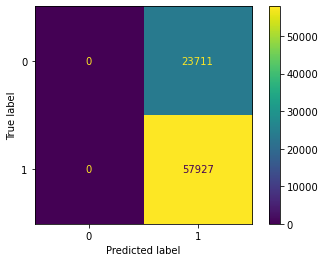

In [157]:
plot_confusion_matrix(dt, X_test_encoded, y_test)

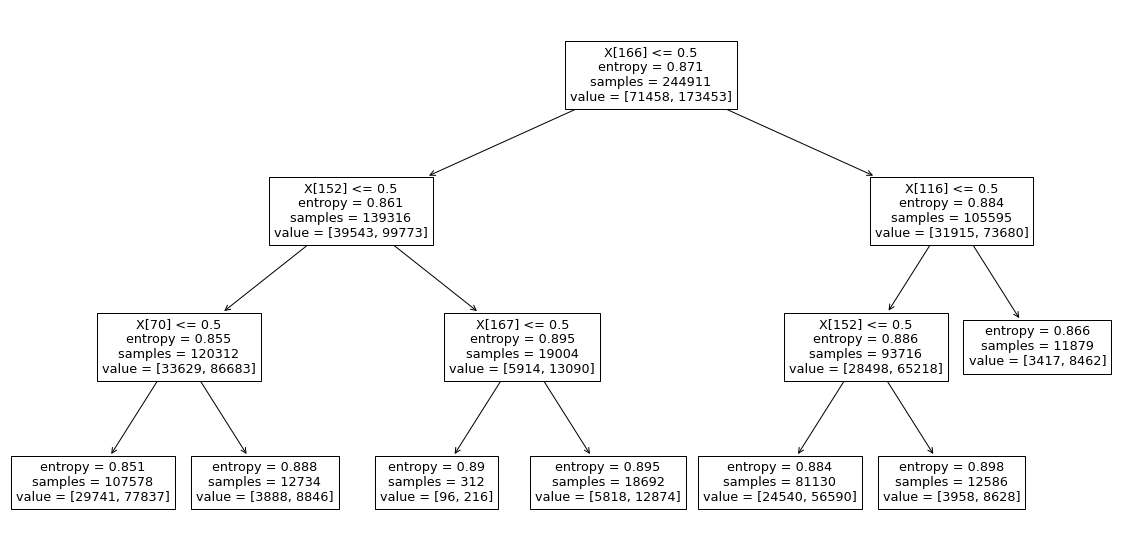

In [158]:
f, ax = plt.subplots(figsize=(20, 10))
plot_tree(dt, ax=ax);

In [151]:
col_names = pd.DataFrame(X_train_encoded.todense(), columns=ohe.get_feature_names())

In [153]:
list(col_names.columns)[166], list(col_names.columns)[152], list(col_names.columns)[116]

('x1_F', 'x0_TOYOTA', 'x0_NISSAN')

## Decision Tree Classifier

In [130]:
# Making a baseline dataframe 

df_dt = df[["VEHICLE_YEAR", "SEX", "DRIVING_SKILLS", "TIME_OF_DAY", "DAMAGE_OVER_1500"]]

In [131]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326549 entries, 3 to 766594
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   VEHICLE_YEAR      326549 non-null  float64
 1   SEX               326549 non-null  object 
 2   DRIVING_SKILLS    326549 non-null  int64  
 3   TIME_OF_DAY       326549 non-null  object 
 4   DAMAGE_OVER_1500  326549 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 14.9+ MB


In [132]:
# Assigning Xs & y 

X_dt = df_dt.drop("DAMAGE_OVER_1500", axis=1)
y_dt = df["DAMAGE_OVER_1500"]

### Train/Test Split

In [133]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, random_state=2024)

### Preprocessing Steps (SS, OHE, SI)

In [134]:
df_dt.isna().sum()

VEHICLE_YEAR        0
SEX                 0
DRIVING_SKILLS      0
TIME_OF_DAY         0
DAMAGE_OVER_1500    0
dtype: int64

In [135]:
encoding = OneHotEncoder(categories="auto", handle_unknown="ignore")
X_train_dt_imp = encoding.fit_transform(X_train_dt)

In [136]:
names = pd.DataFrame(X_train_dt_imp.todense(), columns=encoding.get_feature_names())

### Modeling (look at Coefficients, P-values)

In [137]:
dt = DecisionTreeClassifier(max_depth=2, random_state=2024)
dt.fit(X_train_dt_imp, y_train_dt)

DecisionTreeClassifier(max_depth=2, random_state=2024)

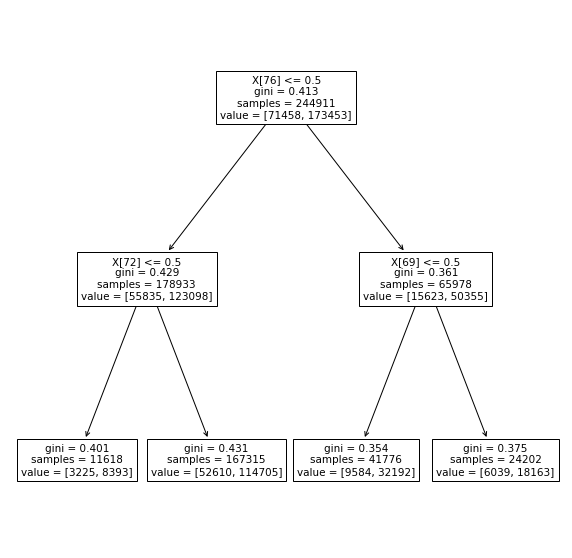

In [138]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(dt, ax=ax);

In [139]:
list(names.columns)[76]

'x3_Evening/Overnight'

In [140]:
list(names.columns)[72]

'x2_0'

In [141]:
list(names.columns)[69]

'x1_F'

In [209]:
list(names.columns)[]

'x4_NONE'

In [210]:
list(names.columns)[]

'x7_1.0'

### Evaluation

So we can see that a model using only the columns which are already numeric is only as good as picking the most frequent.

# Model 3

## Evaluation OF/UF report Test